### Hourly

 ---

### Import

Reload

In [1]:
%load_ext autoreload
%autoreload 2

##### Installed

In [2]:
# base
import time
import sys, os

In [3]:
# processing
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# import gym
import ta
# import tsfresh as tsf
# from sklearn.calibration import CalibratedClassifierCV
# from sklearn.linear_model import LogisticRegression
# from sklearn.preprocessing import StandardScaler
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.gaussian_process import GaussianProcessClassifier
# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [4]:
# connecting
from binance.client import Client
from s3fs.core import S3FileSystem

In [5]:
# d(r)L
import tensorflow as tf

from stable_baselines import PPO2, DQN, A2C
from stable_baselines.common.evaluation import evaluate_policy
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.callbacks import EvalCallback
from stable_baselines.common import make_vec_env

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
init_notebook_mode(connected=True)

##### Local

In [7]:
sys.path.append(os.path.dirname(os.getcwd()))

In [8]:
from cryptoast.utils.misc import list_devices
from cryptoast.utils.cred import Cred
from cryptoast.base.kline import Kline, _Kline, Indicators, _Indicators, Signals, _Signals
from cryptoast.base.klines import Klines, KLMngr
from cryptoast.model.agents import Backtest , SingleAssetEnv

##### Functions

In [9]:
def get_weights(size, method='linear', *args):
    if method in ['linear', 'lin']:
        return np.arange(1, size+1)
    elif method in ['exponential', 'exp']:
        a, b = args
        return a**np.linspace(0, b, size)
    return np.ones(size)

### Initialization

In [10]:
cred = Cred()

In [11]:
bases = ['BTC', 'ETH', 'ADA', 'DOT', 'XRP', 'UNI', 'LTC', 'LINK', 'BCH', 'XLM', 'VET', 'IOTA', 'TRX', 'AAVE', 'ATOM', 'EOS', 'AVAX', 'XEM', 'XTZ', 'BTT', 'NEO', 'ALGO', 'CHZ', 'DASH', 'SNX', 'MKR', 'COMP', 'BAT', 'ZEC', 'ETC', 'UMA', 'WAVES', 'YFI', 'ZRX', 'ONT', 'REN', 'DGB', 'OMG', 'QTUM', 'LSK', 'OCEAN', 'KNC', 'REP', 'BAND', 'KMD', 'ANT', 'DOGE', 'ENJ', 'LTO', 'THETA']

In [12]:
quotes_or_assets = []
quotes_or_assets += [_+'USDT' for _ in bases]
# quotes_or_assets += [_+'BTC' for _ in bases if _ != 'BTC']

In [13]:
root_path = 'admin-invest/'
data_path = root_path+'data/'
store_indicators = None #[_ for _ in Kline._store_indicators_default if _[0] not in ('obv')]
store_signals = None
# store_signals = [
#     ('crossovers', ('sma_50', 'sma_200')),
#     ('trend', ('sma_50', 2)),
#     ('pricecross', ('sma_50',)),
#     ('macdcross', (12, 26)),
#     ('rsicross', (14, 30, 70)),
#     ('rsicross2', ())
# ]

In [14]:
# Remote filesystem - No exchange client

iam_key, iam_secret = cred.get('IAM')
s3 = S3FileSystem(anon=False, key=iam_key, secret=iam_secret)
url_scheme = s3.open

client = Client("a","b")

klmngr = KLMngr(quotes_or_assets=quotes_or_assets, client=client, url_scheme=url_scheme, root_path=root_path,
                store_indicators=store_indicators, store_signals=store_signals)

In [23]:
kline = klmngr['ETHUSDT']

In [ ]:
kline.plot(24*30, signals=kline.signals, signal_type='BUY')

### Update

In [ ]:
print(datetime.utcnow().replace(microsecond=0))

In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

In [ ]:
klmngr.update(verbose=2)

In [ ]:
klmngr.info.reindex(quotes_or_assets).last_update.min()

### Preprocessing

##### Artificial USDT

### Baseline

Single asset

In [23]:
kline = klmngr['ETHUSDT'] # klmngr[klmngr.assets[1]]
print(kline.asset)

ETHUSDT


In [57]:
index = kline.index[:-1].to_frame().rename(columns={0: 'datetime'})
index = index.assign(index=index.datetime.dt.date)
_sigs = kline.signals.eq(1).mean(axis=1).rolling(3).median().shift(1).values[:-1]
# _sigs = kline.signals.eq(1).mean(axis=1).rolling(6).mean().shift(1).values[:-1]
# sigs = np.where(_sigs <= -.6, -1, np.where(_sigs >= .8, 1, 0))
sigs = np.where(_sigs < .2, -1, np.where(_sigs >= .55, 1, 0))

In [58]:
btst = Backtest(kline, start_index=0, init_assets=1, commission=0.001, slippage_pct=0.1, slippage_steps=0)
btst.run(999*sigs, verbose=0)

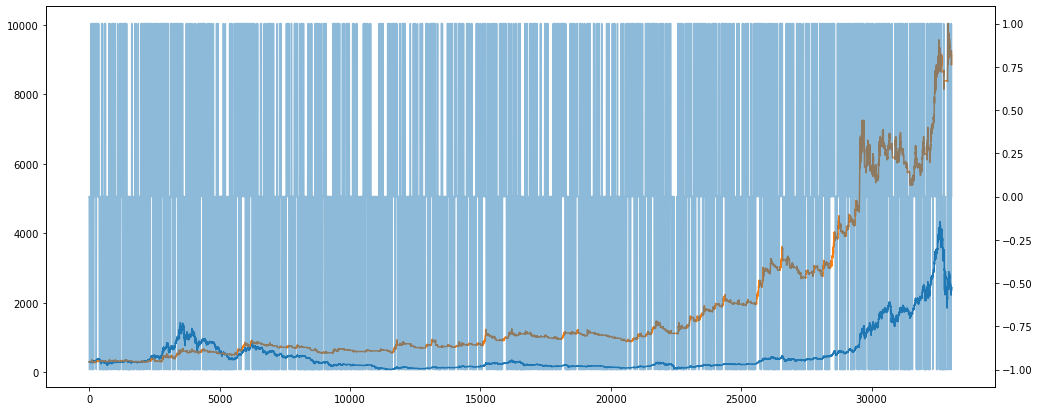

In [59]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

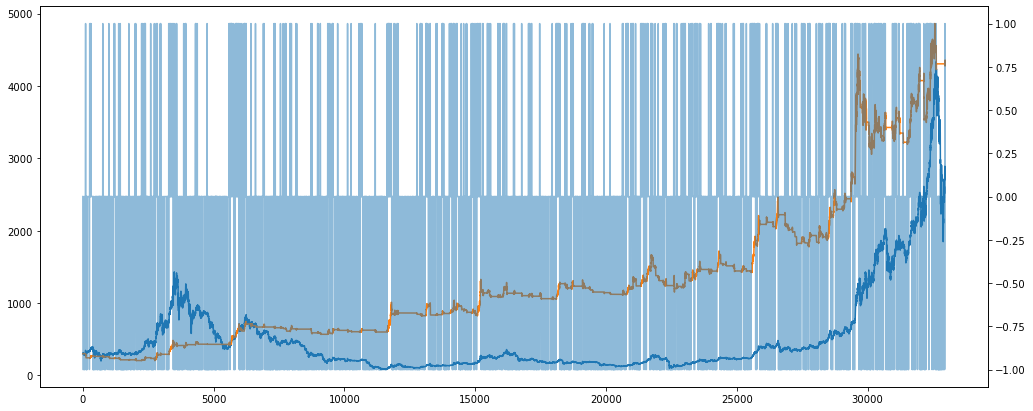

In [21]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

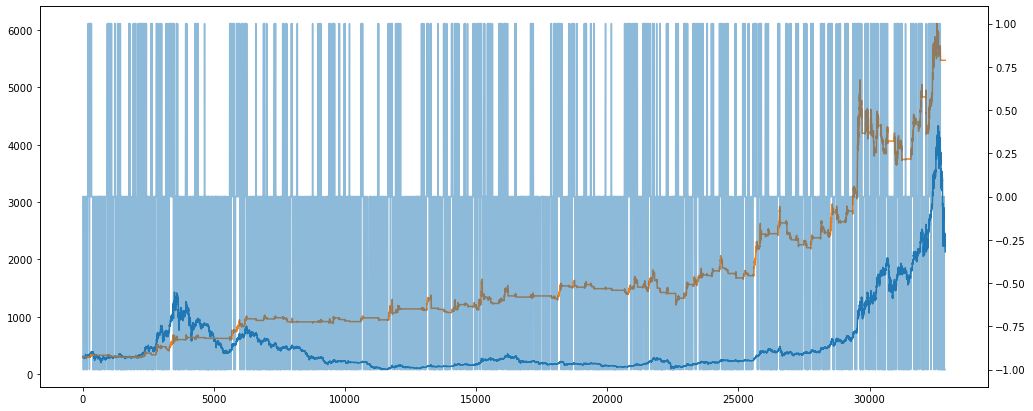

In [18]:
fig, ax = plt.subplots(figsize=(17, 7))
ax.plot(kline.close.values)
ax.plot(btst.periodic.value.values)
ax2 = ax.twinx()
ax2.plot(sigs, alpha=.5)

### Model test 2: RF

##### Manual reloads

In [25]:
from cryptoast.model.agents import SingleAssetEnv

In [26]:
from stable_baselines.common.policies import FeedForwardPolicy, ActorCriticPolicy, register_policy
from stable_baselines.deepq.policies import FeedForwardPolicy as DQNFFP

##### Check for uniform shape within indicators

In [27]:
bad_assets = []

In [18]:
bad_assets = [asset for asset in klmngr.assets if klmngr[asset].indicators.columns.size != 34]
print(bad_assets)

[]


##### Discrete action, Single Process

Define assets

In [28]:
test_assets = ['ETHUSDT']

In [68]:
train_assets = list(set(klmngr.assets)-set(test_assets)-set(bad_assets))

Testing ground

In [32]:
asset = np.random.choice(klmngr.assets) # 'BTCUSDT'
btst = Backtest(kline=klmngr[asset], memory=6)
env = SingleAssetEnv(klmngr, assets=train_assets, backtest=btst, window=1, )

In [34]:
btst = Backtest(kline=klmngr['ETHUSDT'], init_assets=1, memory=6)
env = SingleAssetEnv(klmngr, assets=['ETHUSDT'], backtest=btst, window=1, episode_steps=24*30*12*5, randomize_start=False, allow_gaps=True)

In [138]:
done = False
obs = env.reset()
while not done:
    try:
        obs, reward, done, info = env.step(get_action(obs))
    except Exception as e:
        print(e)
        pass

Out of bounds nanosecond timestamp -9223374705200000000


<AxesSubplot:>

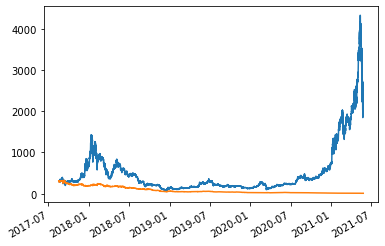

In [139]:
env.kline.loc[env.backtest.periodic.index].close.plot()
env.backtest.periodic.value.plot()

In [136]:
def get_action(obs):
    buy = np.mean([
        obs[0]>obs[1],
        obs[0]<1,
        obs[11]<30,
        obs[13]<1,
        obs[15]<1
    ])
    return 2 if buy >= .8 else (0 if buy <= 6. else 1)

100


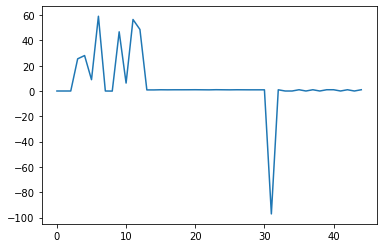

In [22]:
# obs = env.step(np.random.choice([0, 1, 2]))[0]
obs = [env.step(_) for _ in np.random.choice([0, 1, 2], size=100)][-1][0]
print(env.current_step)
plt.plot(obs)

In [35]:
check_env(env)

In [98]:
obs = env.reset()

8.323686554192989


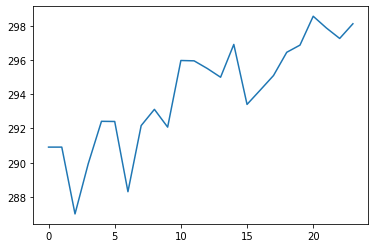

In [187]:
obs, reward, _, __ = env.step(2)
plt.plot(env.kline.close[:env.backtest.position['timestamp']].values[-24:])
print(reward)

-1.0054592164418754


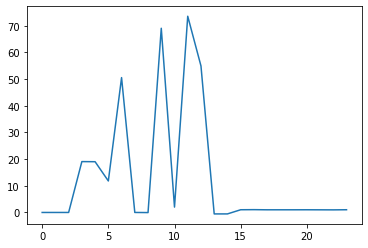

In [49]:
obs, reward, _, __ = env.step(2)
plt.plot(obs[:24])
print(reward)

DQN

In [ ]:
# Custom MLP policy of three layers of size 128 each
class CustomDQNPolicy(DQNFFP):
    def __init__(self, *args, **kwargs):
        super(CustomDQNPolicy, self).__init__(*args, **kwargs,
                                           layers=[64, 64, 64, 64],
                                           layer_norm=True,
                                           feature_extraction="mlp")

In [70]:
train_assets = ['ETHUSDT']

In [71]:
window = 1
btst = Backtest(init_assets=0, init_cash=1000, commission=0.001, slippage_pct=0, slippage_steps=0, memory=6)
env_kwargs = dict(klmngr=klmngr,
                  assets=train_assets,
                  backtest=btst,
                  window=window,
                  datetimes=pd.Timestamp(2020, 1, 1),
                  randomize_start=True,
                  allow_gaps=False,
                  episode_steps=24*30*2)
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [72]:
eval_callback = EvalCallback(env, 
                             best_model_save_path='../models/h5/',
                             log_path='../models/logs/',
                             eval_freq=500,
                             deterministic=True, 
                             render=False)

In [73]:
total_timesteps = 500*1000
tensorboard_log = '../models/logs_tensorboard/' # None
# model = DQN(policy='MlpPolicy', env=env, exploration_fraction=.2, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1, tensorboard_log=tensorboard_log)
# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, verbose=1)

# model = DQN(policy=CustomDQNPolicy, env=env, learning_rate=0.0001, buffer_size=1000000, learning_starts=50000, train_freq=1, prioritized_replay=True, tensorboard_log='C:/Users/guill/Documents/Code/crypto-invest/models/logs', verbose=1)
model = PPO2(policy='MlpPolicy', env=env, verbose=1, tensorboard_log=tensorboard_log, gamma=.9)
# model = A2C(policy='MlpPolicy', env=env, verbose=1)

In [78]:
# model.learn(total_timesteps)
model.learn(total_timesteps, callback=eval_callback)

------------------------------------
| approxkl           | 0.000500405 |
| clipfrac           | 0.0         |
| explained_variance | -0.0507     |
| fps                | 67          |
| n_updates          | 1           |
| policy_entropy     | 1.0981376   |
| policy_loss        | -0.00812964 |
| serial_timesteps   | 128         |
| time_elapsed       | 0           |
| total_timesteps    | 128         |
| value_loss         | 9.671874    |
------------------------------------
--------------------------------------
| approxkl           | 0.00040009068 |
| clipfrac           | 0.0           |
| explained_variance | 0.0298        |
| fps                | 85            |
| n_updates          | 2             |
| policy_entropy     | 1.0953987     |
| policy_loss        | -0.005954831  |
| serial_timesteps   | 256           |
| time_elapsed       | 1.9           |
| total_timesteps    | 256           |
| value_loss         | 8.939874      |
--------------------------------------
------------

Eval num_timesteps=2000, episode_reward=3.18 +/- 46.00
Episode length: 877.60 +/- 469.32
-------------------------------------
| approxkl           | 0.002452962  |
| clipfrac           | 0.0          |
| ep_len_mean        | 260          |
| ep_reward_mean     | -102         |
| explained_variance | -0.156       |
| fps                | 3            |
| n_updates          | 16           |
| policy_entropy     | 0.7855655    |
| policy_loss        | -0.009394876 |
| serial_timesteps   | 2048         |
| time_elapsed       | 97.6         |
| total_timesteps    | 2048         |
| value_loss         | 2.39357      |
-------------------------------------
--------------------------------------
| approxkl           | 0.00028547482 |
| clipfrac           | 0.0           |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | 0.0481        |
| fps                | 113           |
| n_updates          | 17            |
| policy_entropy     | 0.7271

-------------------------------------
| approxkl           | 0.0014088817 |
| clipfrac           | 0.00390625   |
| ep_len_mean        | 260          |
| ep_reward_mean     | -102         |
| explained_variance | 0.0341       |
| fps                | 94           |
| n_updates          | 30           |
| policy_entropy     | 0.51659757   |
| policy_loss        | -0.004002129 |
| serial_timesteps   | 3840         |
| time_elapsed       | 292          |
| total_timesteps    | 3840         |
| value_loss         | 0.90362567   |
-------------------------------------
--------------------------------------
| approxkl           | 5.6749377e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | -0.0204       |
| fps                | 95            |
| n_updates          | 31            |
| policy_entropy     | 0.47030294    |
| policy_loss        | 7.983763e-06  |
| serial_timesteps   | 3968          |
|

--------------------------------------
| approxkl           | 0.00025629764 |
| clipfrac           | 0.0           |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | -0.019        |
| fps                | 92            |
| n_updates          | 44            |
| policy_entropy     | 0.24893332    |
| policy_loss        | -0.00189898   |
| serial_timesteps   | 5632          |
| time_elapsed       | 483           |
| total_timesteps    | 5632          |
| value_loss         | 0.8826876     |
--------------------------------------
---------------------------------------
| approxkl           | 9.559058e-05   |
| clipfrac           | 0.001953125    |
| ep_len_mean        | 260            |
| ep_reward_mean     | -102           |
| explained_variance | 0.000112       |
| fps                | 88             |
| n_updates          | 45             |
| policy_entropy     | 0.24303055     |
| policy_loss        | -0.00020223612 |
| serial_timest

--------------------------------------
| approxkl           | 4.2876367e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | -0.0197       |
| fps                | 104           |
| n_updates          | 58            |
| policy_entropy     | 0.12461152    |
| policy_loss        | -0.0010981583 |
| serial_timesteps   | 7424          |
| time_elapsed       | 612           |
| total_timesteps    | 7424          |
| value_loss         | 2.576516      |
--------------------------------------
Eval num_timesteps=7500, episode_reward=-21.53 +/- 24.21
Episode length: 960.60 +/- 574.29
--------------------------------------
| approxkl           | 1.6216936e-05 |
| clipfrac           | 0.0           |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | -0.0617       |
| fps                | 2             |
| n_updates          | 59            |
| policy_ent

---------------------------------------
| approxkl           | 3.4497083e-05  |
| clipfrac           | 0.0            |
| ep_len_mean        | 260            |
| ep_reward_mean     | -102           |
| explained_variance | 0.079          |
| fps                | 95             |
| n_updates          | 72             |
| policy_entropy     | 0.2235004      |
| policy_loss        | -0.00049955107 |
| serial_timesteps   | 9216           |
| time_elapsed       | 790            |
| total_timesteps    | 9216           |
| value_loss         | 1.738819       |
---------------------------------------
--------------------------------------
| approxkl           | 0.00016246938 |
| clipfrac           | 0.001953125   |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | 0.0158        |
| fps                | 95            |
| n_updates          | 73            |
| policy_entropy     | 0.22958374    |
| policy_loss        | -0.002836316  |
| serial_t

Eval num_timesteps=11000, episode_reward=-17.94 +/- 16.66
Episode length: 869.20 +/- 470.29
--------------------------------------
| approxkl           | 0.00080330565 |
| clipfrac           | 0.015625      |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | -0.135        |
| fps                | 3             |
| n_updates          | 86            |
| policy_entropy     | 0.40606433    |
| policy_loss        | -0.003984589  |
| serial_timesteps   | 11008         |
| time_elapsed       | 919           |
| total_timesteps    | 11008         |
| value_loss         | 1.2892246     |
--------------------------------------
--------------------------------------
| approxkl           | 0.00032800427 |
| clipfrac           | 0.005859375   |
| ep_len_mean        | 260           |
| ep_reward_mean     | -102          |
| explained_variance | 0.0701        |
| fps                | 104           |
| n_updates          | 87            |
| policy_en

KeyboardInterrupt: 

In [81]:
btst = Backtest(init_assets=1, init_cash=0, commission=0.001, slippage_pct=0, slippage_steps=0, memory=6)
env_kwargs.update(dict(assets=test_assets,
                       backtest=btst,
                       datetimes=(pd.Timestamp(2020, 1, 1), pd.Timestamp(2050, 1, 1)),
                       randomize_start=False,
                       allow_gaps=True,
                       episode_steps=-1,
                      )
                 )
env = SingleAssetEnv(**env_kwargs)
env = make_vec_env(lambda: env, n_envs=1)

In [ ]:
model.load(load_path='../models/h5/best_model.zip', env=env)

In [ ]:
model.load_parameters(load_path_or_dict='../models/h5/best_model.zip')

In [82]:
print('n_step:', klmngr[test_assets[0]].loc[btst.position['timestamp']:].shape[0])

n_step: 12354


In [83]:
n_steps = 12354
vec_env = not(isinstance(env, SingleAssetEnv))
print(vec_env)

True


In [84]:
obs = env.reset()
reward_list = []
action_list = []
values_dict = dict()
for step in range(n_steps):
    t0 = time.time()
#     action, _ = model.predict(obs, deterministic=False)
    action = [np.random.choice([0, 1, 2], p=model.action_probability(obs)[0])]
    obs, reward, done, info = env.step(action)
    if vec_env:
        reward_list.append(reward[0])
        action_list.append(action[0])
        values_dict = {**values_dict, **info[0]['periodic']}
    else:
        reward_list.append(reward)
        action_list.append(action)
        values_dict = {**values_dict, **info['periodic']}
    # env.render(mode='console')
    t1 = time.time()
    # if step%1000==0:
    #     print(step, ':', (t1-t0)/60)
    if done:
        print("Goal reached!", "reward=", reward)
        break

Goal reached! reward= [1.0052372]


In [85]:
pd.value_counts(action_list)

2    11307
1     1019
0       26
dtype: int64

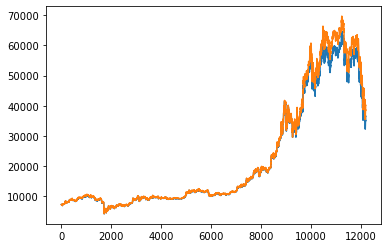

In [155]:
# PPO new - load
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

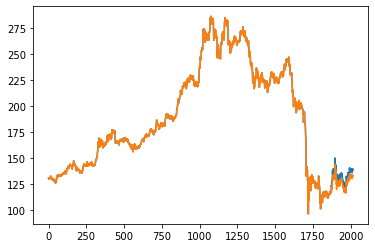

In [122]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

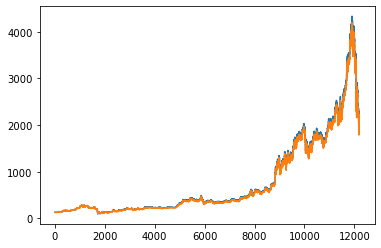

In [123]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

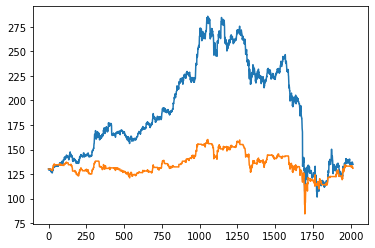

In [161]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

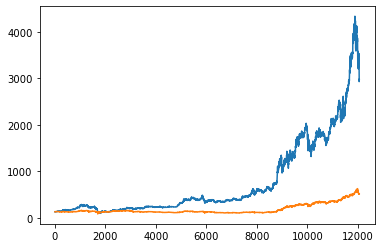

In [162]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

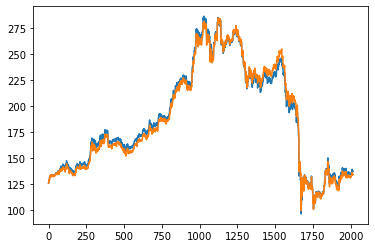

In [28]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

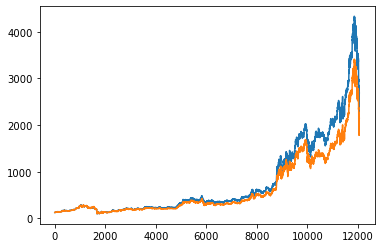

In [29]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

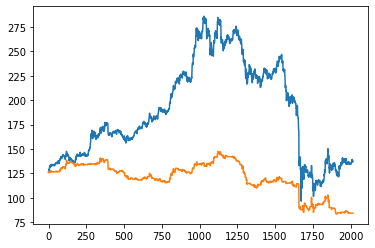

In [75]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

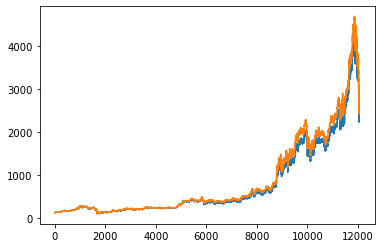

In [37]:
# PPO true - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

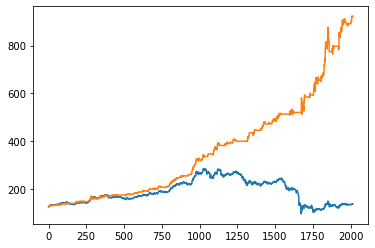

In [41]:
# PPO new - load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


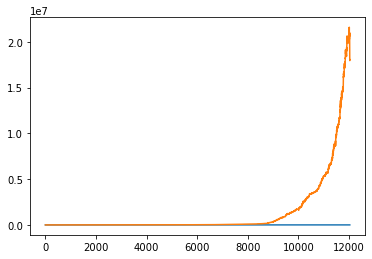

In [42]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

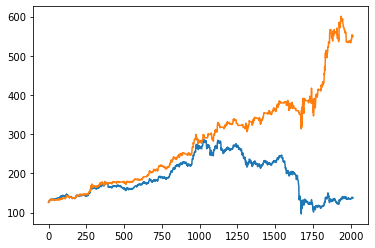

In [36]:
# PPO new
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

500K


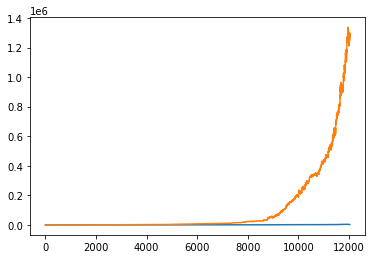

In [35]:
# PPO new
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


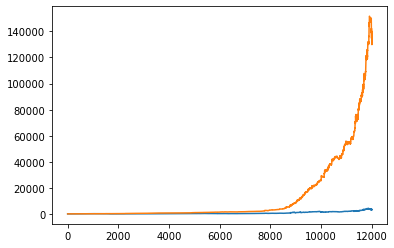

In [152]:
# PPO load
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

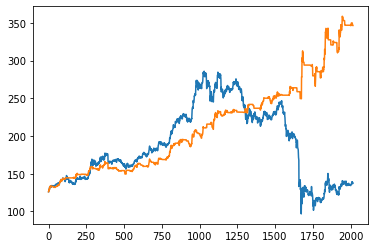

In [153]:
# PPO load
plt.plot(klmngr['ETHUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

<AxesSubplot:>

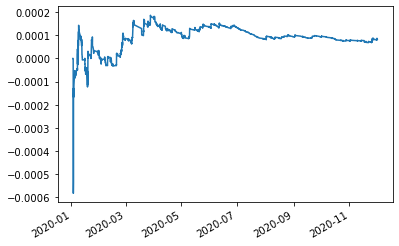

In [133]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

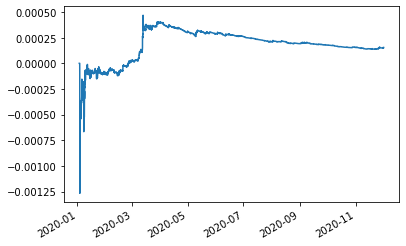

In [194]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

<AxesSubplot:>

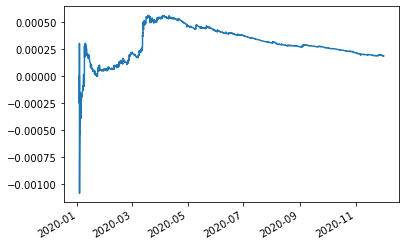

In [220]:
(pd.DataFrame(values_dict).T.value.pct_change() - klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.pct_change()).expanding().mean().plot()

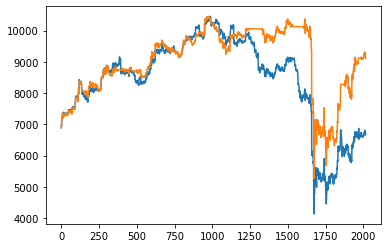

In [129]:
# DQN
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

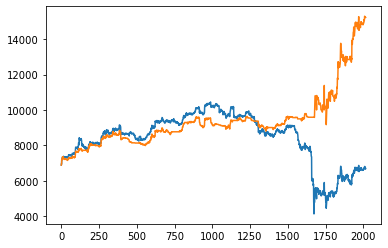

In [195]:
# PPO last
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

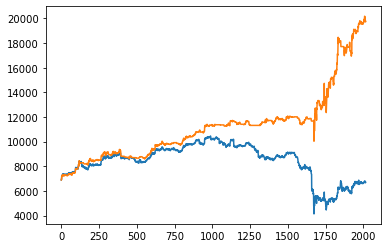

In [221]:
# PPO best
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values[:24*7*4*3])
plt.plot(pd.DataFrame(values_dict).T.value.values[:24*7*4*3])

250K


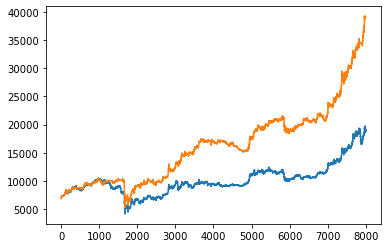

In [112]:
# DQN
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


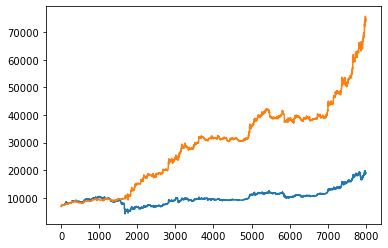

In [196]:
# PPO last
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)

500K


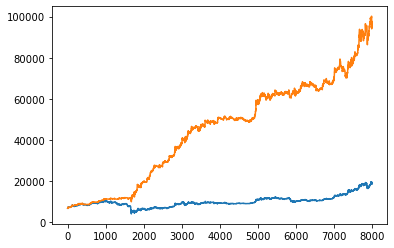

In [222]:
# PPO best
print('{}K'.format(int(total_timesteps/1000)))
plt.plot(klmngr['BTCUSDT'].loc[pd.DataFrame(values_dict).T.index].close.values)
plt.plot(pd.DataFrame(values_dict).T.value.values)